<a href="https://colab.research.google.com/github/anushahulbatte/deeplearning/blob/main/Task1_a_validationset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The runtime will need to be restarted if numpy raises an error.

The notebook contains code for building a 1D-CNN based on simulated dataset. The model looks at motifs in the protein sequences and determines where the protein performs a certain function. This is a case of binary classification.

In [49]:
import torch

if torch.__version__ != '2.5.1+cu124':
    !pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 -U --quiet
    print("PyTorch version updated to 2.5.1.")
else:
    print("PyTorch is already at the correct version (2.5.1).")

PyTorch is already at the correct version (2.5.1).


In [50]:
!pip install d2l==1.0.3 --quiet
!pip install scipy --quiet
!pip install torchmetrics --quiet

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler, random_split

from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

DEVICE = torch.device("cpu")

In [52]:
import random
import os
import matplotlib.pyplot as plt
import csv
import numpy as np

In [53]:
import os
! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git
os.chdir("grs34806-deep-learning-project-data")

Cloning into 'grs34806-deep-learning-project-data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21 (from 1)
Receiving objects: 100% (21/21), 8.74 MiB | 8.49 MiB/s, done.


Writing a function to read the simulated data and produce lists containing the sequences and a separate list containing the sequence identifiers.
Another functionw as defined to create a list for the positively annotated file. This function represented the sequence identifiers found in the sequence file and the positively annotated file as 1s, and those which were not present were represented as 0.

In [54]:
def read(seqfile, posfile):
  """
  Extracting the sequences from the seqfile and creating a list called datalist.
  Making a list called labellist containing 0s and 1s, where 1 denotes the
  sequence identifiers in the posfile.
  """
  # Removing the sequence identifiers
  with open(seqfile, 'r') as f:
    seq_lines = [seq_lines.strip() for seq_lines in f.readlines() if seq_lines.strip()]
    #print(seq_lines)
  seq_ids = []
  datalist = []
  current_seq = ""
  for line in seq_lines:
    if line.startswith("seq"):
      parts = line.split()
      #print(parts)
      seq_ids.append(parts[0])
      datalist.append(parts[1])

  with open(posfile, 'r') as f:
    annotated_ids = [line.strip() for line in f.readlines() if line.strip()]
    #print(annotated_ids)
  labellist = [1 if seq_id in annotated_ids else 0 for seq_id in seq_ids]

  print("Length of the datalist: ", len(datalist))
  print("Length of labellist: ", len(labellist))
  print("The number of positives in labellist: ", sum(labellist))
  #for i in range(min(5, len(datalist))):
        #print(f"ID: {seq_ids[i]}, Has annotation: {labellist[i]}, Sequence length: {len(datalist[i])}")

  return datalist, labellist

In [55]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/len100_200_n1000.seq",
posfile = "/content/grs34806-deep-learning-project-data/len100_200_n1000.pos")

Length of the datalist:  1000
Length of labellist:  1000
The number of positives in labellist:  507


Splitting the dataset into a training, validation and test set.
This helps the model to perform well on unseen data, and prevents from the occurrence of overfitting.

In [56]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_train_val_test(datalist, labellist, test_size=0.2, val_size=0.25,
                            random_state=42):
  """
  First splitting the data into training and testing sets.
  And then separating the training set into a validation set.
  This is done in a 60%, 20% and 20% manner.
  """
  trainval_data, test_data, trainval_labels, test_labels = train_test_split(
      datalist, labellist, test_size=test_size,
      random_state = random_state
  )

  train_data, val_data, train_labels, val_labels = train_test_split(
      trainval_data, trainval_labels, test_size=val_size,
      random_state=random_state
  )

  return train_data, val_data, test_data, train_labels, val_labels, test_labels

In [57]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = generate_train_val_test(
    datalist, labellist
)

In [58]:
print("Training data size:", len(train_data))
print("Training labels size:", len(train_labels))
print("Validation data size: ", len(val_data))
print("Validation labels size: ", len(val_labels))
print("Test data size:", len(test_data))
print("Test labels size:", len(test_labels))

Training data size: 600
Training labels size: 600
Validation data size:  200
Validation labels size:  200
Test data size: 200
Test labels size: 200


The tokenise function takes the amino acids from the protein sequences and maps it to unique integers. For amino acids which are uncommon or unknown, it is given the value of 20.

In [59]:
def tokenize(dat, map2num, non_aa_num=20):
  """
  This function takes in the sequences of AA. It uses dictionary mapping, to map
  AA to integers. The non_aa_num make up the unknown AA, and its default value is
  20.
  """
  seq = []
  for count, i in enumerate(dat):
      seq.append([map2num.get(j, non_aa_num) for j in list(i)])
  return seq

This function ensures all the sequence lengths are the same. This is done by padding the sequences which are shorter. The sequences are then converted into tensors, which is the required form of the input for a CNN.

In [60]:
def build_seq_array(lines, num_steps, non_aa_num=20):
  """
  This function applies the truncate_pad function to all the sequences.
  It then converts the sequences into tensors.
  """
  array = torch.tensor([
      truncate_pad(l, num_steps, non_aa_num) for l in lines])
  return array

In [61]:
def truncate_pad(line, num_steps, padding_token):
  """
  The line in the parameters refers to the tokenized sequence.
  num_steps is the maxmimum sequence length. The padding_token is the integer
  for padding.
  The function pads shorter sequences with padding_token.
  """
  if len(line) > num_steps:
    return line[:num_steps] #Truncate
  return line + [padding_token] * (num_steps - len(line))

In [62]:
from d2l import torch as d2l

Function load_data compiles all the above pre-defined functions into 1. Additionally, it includes code to represent the sequences as one-hot encoded vectors instead of unique integers.

In [63]:
def load_data(batch_size, num_steps, dataset, trainlabels = None):
  mapaa2num = {aa: i for (i, aa)
                      in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
  # Creating a dictionary which maps each AA to a unique integer
  seq, lab = dataset, trainlabels # lab is the labels which are associated with sequences

  seq = tokenize(seq, mapaa2num)
  seq_array = build_seq_array(seq, num_steps) # Shape = batch_size, num_steps

  # To convert the sequences to one-hot encoding
  # one_hot method takes a tensor and returns a tensor of shape of num_classes
  vocab_size = len(mapaa2num) + 1
  seq_onehotencoding = F.one_hot(seq_array, num_classes=vocab_size).float()
  seq_onehotencoding = seq_onehotencoding.permute(0,2,1)
  # Shape = batch_size, vocab_size, num_steps

  data_arrays = (seq_onehotencoding, torch.tensor(lab))
  #data_arrays = (seq_array, torch.tensor(lab))
  data_iter = d2l.load_array(data_arrays, batch_size)
  #print("Shape of seq_array: ", seq_array.shape)
  #print("Shape of data_arrays, which now considers \none-hot encoded sequence: ",
        #seq_onehotencoding.shape)
  return data_iter

In [64]:
print("Unique labels:", torch.unique(torch.tensor(train_labels)))

Unique labels: tensor([0, 1])


In [65]:
train_iter = load_data(batch_size = 25, num_steps=100, dataset=train_data, trainlabels=train_labels)
validation_iter = load_data(batch_size=25, num_steps=100, dataset=val_data, trainlabels=val_labels)
test_iter = load_data(batch_size= 25, num_steps = 100, dataset = test_data, trainlabels = test_labels)

Building the CNN model. This architecture contains 3 convolutional layers and 2 linear layers. A kernel size of 3 has been used in this model, but has not been implemented with batch normalisation.
A binary cross entropy was used for the loss function and is used for binary classifications tasks such as this one.  

In [66]:
class ProteinCNN1D(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4,
               momentum = 0):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Flatten(),
          nn.Linear(in_features = int(128*(self.context_size//8)),
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



Trying the model with:

*   Batch size = 32
*   Context_size = 100
*   Learning_tate = 1e-3
*   Dropout_rate = 0.5
*   Num_epochs = 10

Implementing early stopping using the validation set to prevent overfitting of the model on the data.



In [67]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6973, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6979, Validation Accuracy: 0.4750
Epoch 3: Train Loss: 0.6940, Validation Accuracy: 0.5150
Epoch 4: Train Loss: 0.6951, Validation Accuracy: 0.5250
Epoch 5: Train Loss: 0.6937, Validation Accuracy: 0.5150
Epoch 6: Train Loss: 0.6928, Validation Accuracy: 0.5250
Epoch 7: Train Loss: 0.6862, Validation Accuracy: 0.5300
Epoch 8: Train Loss: 0.6280, Validation Accuracy: 0.8050
Epoch 9: Train Loss: 0.4356, Validation Accuracy: 0.7850
Epoch 10: Train Loss: 0.3749, Validation Accuracy: 0.8150

Final Test Accuracy: 0.8650


Checking the performance of the model without implementing early stopping. The function also plots the accuracies and loss of the train, validation and test sets.
The function also defines the loss and accuracy for every epoch, compared to the previous code which returns the final loss and validation accuracy.

Epoch 1: Train Loss: 0.7005, Val Loss: 0.6925, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 2: Train Loss: 0.6966, Val Loss: 0.6935, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 3: Train Loss: 0.6940, Val Loss: 0.6934, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 4: Train Loss: 0.6943, Val Loss: 0.6947, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 5: Train Loss: 0.6944, Val Loss: 0.6930, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 6: Train Loss: 0.6922, Val Loss: 0.6926, Val Acc: 0.5200, Test Acc: 0.5250
Epoch 7: Train Loss: 0.6849, Val Loss: 0.6984, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 8: Train Loss: 0.6836, Val Loss: 0.6859, Val Acc: 0.4800, Test Acc: 0.4800
Epoch 9: Train Loss: 0.6060, Val Loss: 0.5516, Val Acc: 0.7600, Test Acc: 0.7950
Epoch 10: Train Loss: 0.4765, Val Loss: 0.4814, Val Acc: 0.8100, Test Acc: 0.8650


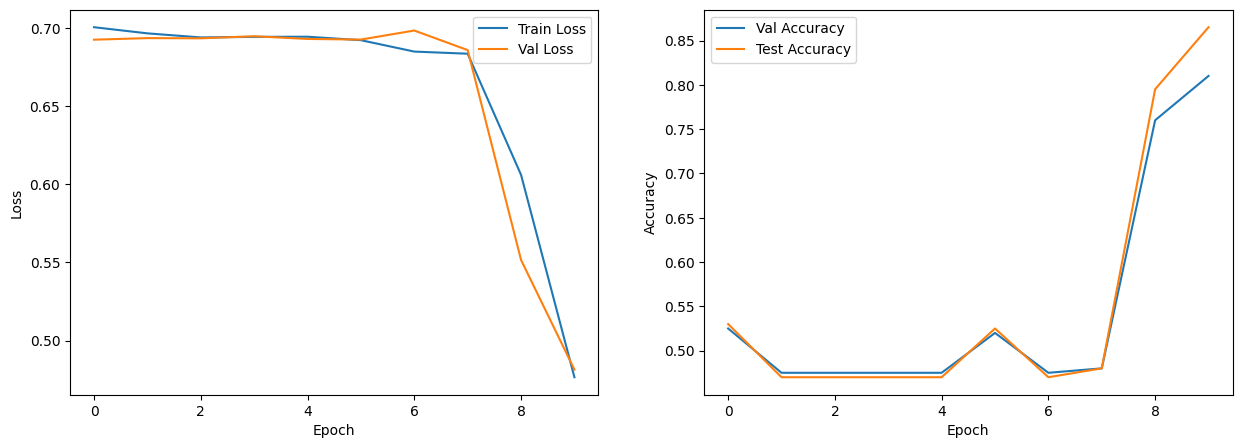

In [68]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Implementing the same parameters as before, but with a weight decay value of 0.001

In [69]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 0.001
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
    weight_decay = weight_decay
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6989, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6945, Validation Accuracy: 0.5500
Epoch 3: Train Loss: 0.6932, Validation Accuracy: 0.5250
Epoch 4: Train Loss: 0.6934, Validation Accuracy: 0.4750
Epoch 5: Train Loss: 0.6904, Validation Accuracy: 0.5050
Epoch 6: Train Loss: 0.6895, Validation Accuracy: 0.4750
Epoch 7: Train Loss: 0.6890, Validation Accuracy: 0.6800
Epoch 8: Train Loss: 0.6295, Validation Accuracy: 0.7900
Epoch 9: Train Loss: 0.4921, Validation Accuracy: 0.8100
Epoch 10: Train Loss: 0.3775, Validation Accuracy: 0.8150

Final Test Accuracy: 0.8550


Epoch 1: Train Loss: 0.7028, Val Loss: 0.6936, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 2: Train Loss: 0.6949, Val Loss: 0.6931, Val Acc: 0.5300, Test Acc: 0.5050
Epoch 3: Train Loss: 0.6942, Val Loss: 0.6933, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 4: Train Loss: 0.6938, Val Loss: 0.6931, Val Acc: 0.5250, Test Acc: 0.5150
Epoch 5: Train Loss: 0.6923, Val Loss: 0.6928, Val Acc: 0.6100, Test Acc: 0.5850
Epoch 6: Train Loss: 0.6894, Val Loss: 0.6873, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 7: Train Loss: 0.6737, Val Loss: 0.6448, Val Acc: 0.7750, Test Acc: 0.7900
Epoch 8: Train Loss: 0.4950, Val Loss: 0.4393, Val Acc: 0.8150, Test Acc: 0.8500
Epoch 9: Train Loss: 0.3961, Val Loss: 0.4140, Val Acc: 0.8200, Test Acc: 0.8650
Epoch 10: Train Loss: 0.3947, Val Loss: 0.4028, Val Acc: 0.8200, Test Acc: 0.8650


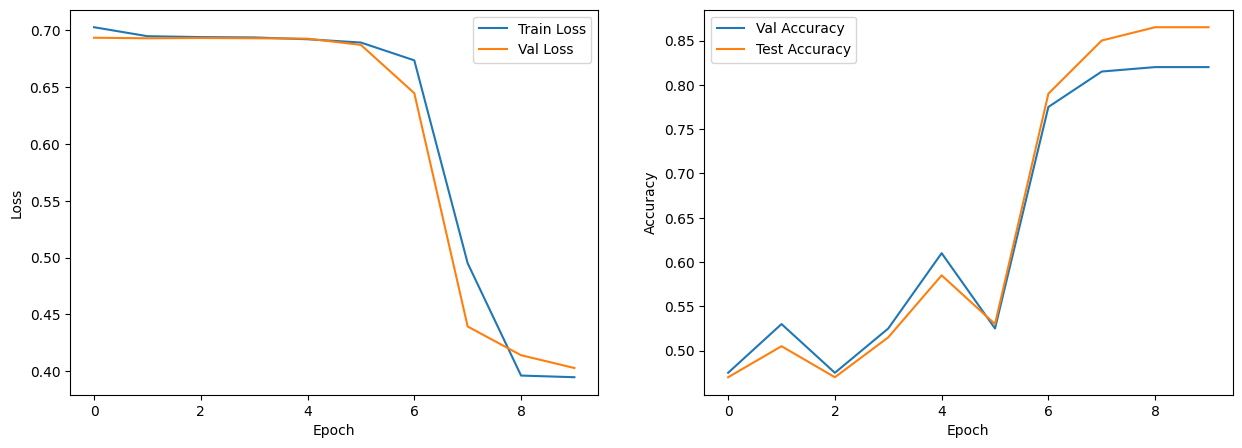

In [70]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 0.001

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing with a dropout rate of 0.2, whilst keeping all the other parameters the same to really evaluate the effect of changing this hyperparameter.

In [71]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.2
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
    weight_decay = weight_decay
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6970, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6983, Validation Accuracy: 0.4750
Epoch 3: Train Loss: 0.6924, Validation Accuracy: 0.4750
Epoch 4: Train Loss: 0.6938, Validation Accuracy: 0.4750
Epoch 5: Train Loss: 0.6923, Validation Accuracy: 0.4750
Epoch 6: Train Loss: 0.6931, Validation Accuracy: 0.5250
Epoch 7: Train Loss: 0.6961, Validation Accuracy: 0.4750
Epoch 8: Train Loss: 0.6932, Validation Accuracy: 0.5250
Epoch 9: Train Loss: 0.6876, Validation Accuracy: 0.4750
Epoch 10: Train Loss: 0.6667, Validation Accuracy: 0.7200

Final Test Accuracy: 0.7700


Epoch 1: Train Loss: 0.7033, Val Loss: 0.6931, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 2: Train Loss: 0.6937, Val Loss: 0.6941, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 3: Train Loss: 0.6958, Val Loss: 0.6929, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 4: Train Loss: 0.6949, Val Loss: 0.6930, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 5: Train Loss: 0.6936, Val Loss: 0.6931, Val Acc: 0.4800, Test Acc: 0.5600
Epoch 6: Train Loss: 0.6927, Val Loss: 0.6928, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 7: Train Loss: 0.6931, Val Loss: 0.6942, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 8: Train Loss: 0.6943, Val Loss: 0.6902, Val Acc: 0.5600, Test Acc: 0.5650
Epoch 9: Train Loss: 0.6724, Val Loss: 0.6442, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 10: Train Loss: 0.5531, Val Loss: 0.4619, Val Acc: 0.7850, Test Acc: 0.8400


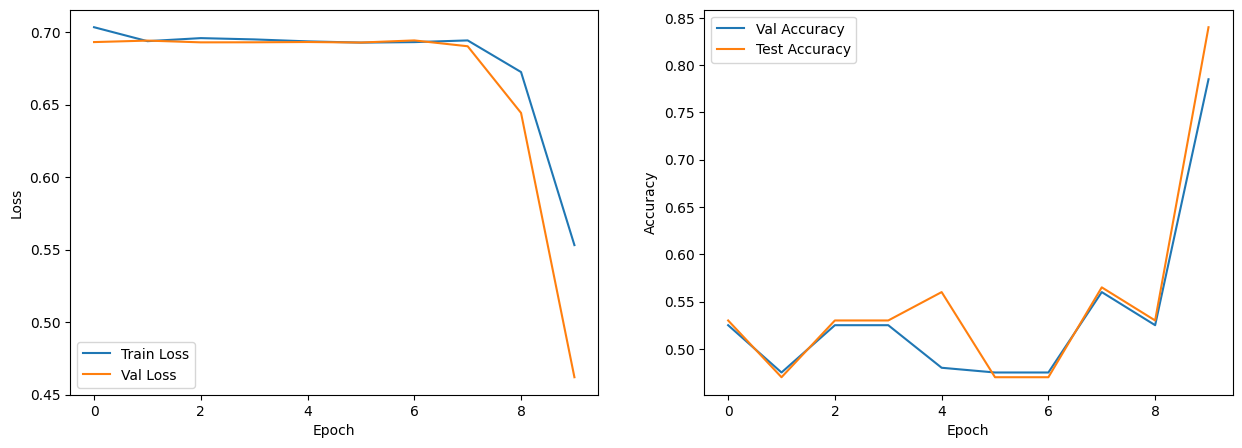

In [72]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.2
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

To test the hyperparameter momentum, and its effect we change the optimizer. Studies have shown that moomentum greatly helps in increasing the accuracy of a model with a SGD optimizer. However, studies have shown that SGD optimizer performs very poorly for binary classification tasks and therefore we predict the model will not have a high accuracy.

In [73]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
momentum = 0.5
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using SGD as the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay, momentum=momentum)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6933, Validation Accuracy: 0.4600
Epoch 2: Train Loss: 0.6930, Validation Accuracy: 0.4650
Epoch 3: Train Loss: 0.6941, Validation Accuracy: 0.4600
Epoch 4: Train Loss: 0.6930, Validation Accuracy: 0.4650
Epoch 5: Train Loss: 0.6934, Validation Accuracy: 0.4650
Epoch 6: Train Loss: 0.6932, Validation Accuracy: 0.4650
Epoch 7: Train Loss: 0.6933, Validation Accuracy: 0.4650
Early stopping triggered at epoch 7

Final Test Accuracy: 0.4350


Epoch 1: Train Loss: 0.6935, Val Loss: 0.6932, Val Acc: 0.4850, Test Acc: 0.4750
Epoch 2: Train Loss: 0.6928, Val Loss: 0.6932, Val Acc: 0.4900, Test Acc: 0.4750
Epoch 3: Train Loss: 0.6926, Val Loss: 0.6931, Val Acc: 0.4850, Test Acc: 0.4800
Epoch 4: Train Loss: 0.6926, Val Loss: 0.6931, Val Acc: 0.4900, Test Acc: 0.4750
Epoch 5: Train Loss: 0.6925, Val Loss: 0.6932, Val Acc: 0.4900, Test Acc: 0.4750
Epoch 6: Train Loss: 0.6939, Val Loss: 0.6931, Val Acc: 0.4900, Test Acc: 0.4750
Epoch 7: Train Loss: 0.6929, Val Loss: 0.6931, Val Acc: 0.4900, Test Acc: 0.4750
Epoch 8: Train Loss: 0.6934, Val Loss: 0.6932, Val Acc: 0.4900, Test Acc: 0.4750
Epoch 9: Train Loss: 0.6926, Val Loss: 0.6934, Val Acc: 0.4900, Test Acc: 0.4750
Epoch 10: Train Loss: 0.6937, Val Loss: 0.6932, Val Acc: 0.4900, Test Acc: 0.4750


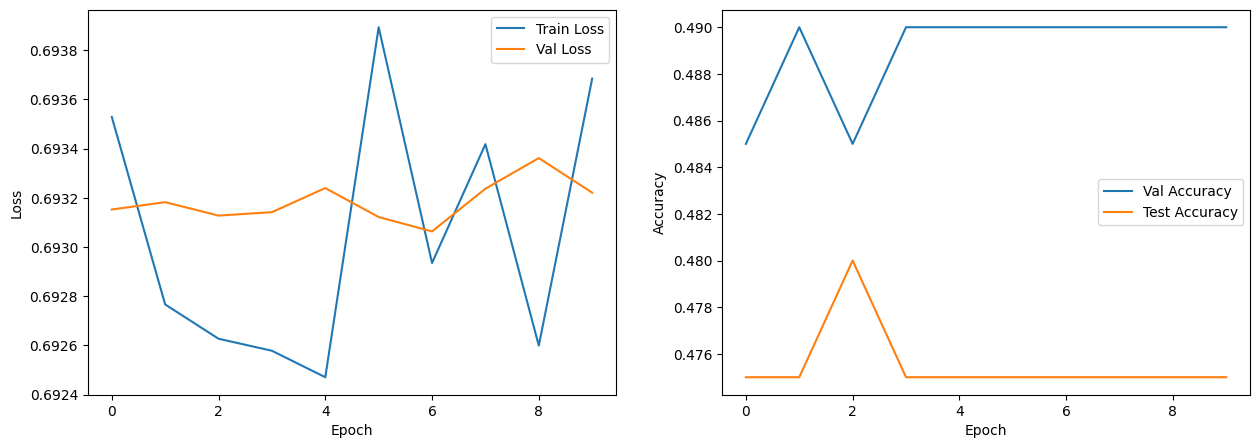

In [74]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
momentum=0.5
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay,
                            momentum=momentum)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As expected, the model performed pooly when using the SGD optimizer, despite making use of the momentum hyperparameter.

Increasing the batch size, going from 32 to 64, and using AdamW optimizer as performance with SGD optimizer was not optimal.

In [75]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6984, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6956, Validation Accuracy: 0.5150
Epoch 3: Train Loss: 0.6946, Validation Accuracy: 0.4750
Epoch 4: Train Loss: 0.6941, Validation Accuracy: 0.5250
Epoch 5: Train Loss: 0.6933, Validation Accuracy: 0.4750
Epoch 6: Train Loss: 0.6903, Validation Accuracy: 0.4750
Epoch 7: Train Loss: 0.6868, Validation Accuracy: 0.4750
Epoch 8: Train Loss: 0.6978, Validation Accuracy: 0.5250
Epoch 9: Train Loss: 0.6715, Validation Accuracy: 0.5600
Epoch 10: Train Loss: 0.5431, Validation Accuracy: 0.8050

Final Test Accuracy: 0.8350


Epoch 1: Train Loss: 0.6997, Val Loss: 0.6933, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 2: Train Loss: 0.6901, Val Loss: 0.6953, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 3: Train Loss: 0.6942, Val Loss: 0.6928, Val Acc: 0.5600, Test Acc: 0.5600
Epoch 4: Train Loss: 0.6915, Val Loss: 0.6921, Val Acc: 0.5250, Test Acc: 0.5300
Epoch 5: Train Loss: 0.6908, Val Loss: 0.6910, Val Acc: 0.5250, Test Acc: 0.5400
Epoch 6: Train Loss: 0.6867, Val Loss: 0.6977, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 7: Train Loss: 0.6707, Val Loss: 0.6678, Val Acc: 0.5350, Test Acc: 0.5700
Epoch 8: Train Loss: 0.6134, Val Loss: 0.6014, Val Acc: 0.7700, Test Acc: 0.8000
Epoch 9: Train Loss: 0.4755, Val Loss: 0.4766, Val Acc: 0.7700, Test Acc: 0.8350
Epoch 10: Train Loss: 0.3918, Val Loss: 0.4233, Val Acc: 0.8200, Test Acc: 0.8550


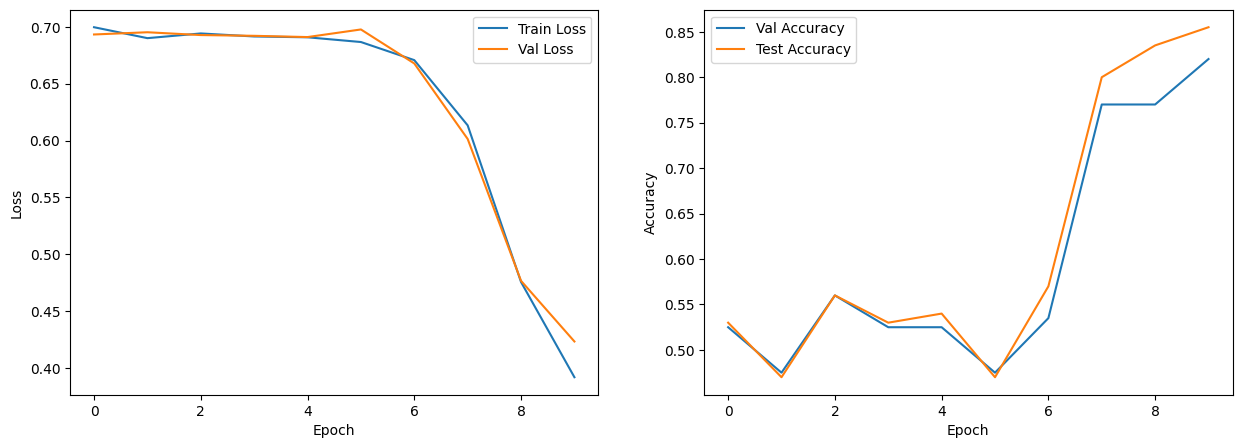

In [76]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Implementing Batch Norm in the architecture to test how batch normalisation helps with improving the quality of the model.

In [77]:
class BatchNorm_ProteinCNN1D(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4
               ):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.BatchNorm1d(conv_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.AdaptiveAvgPool1d(1),
          nn.Flatten(),
          nn.Linear(#in_features = int(128*(self.context_size//8)),
                    in_features = 128,
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



Running the Batch normalisation CNN model with same hyperparameters but different batch sizes.

In [78]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6713, Validation Accuracy: 0.6850
Epoch 2: Train Loss: 0.5503, Validation Accuracy: 0.7800
Epoch 3: Train Loss: 0.4545, Validation Accuracy: 0.7900
Epoch 4: Train Loss: 0.3959, Validation Accuracy: 0.8000
Epoch 5: Train Loss: 0.3555, Validation Accuracy: 0.8000
Epoch 6: Train Loss: 0.3221, Validation Accuracy: 0.8000
Epoch 7: Train Loss: 0.2837, Validation Accuracy: 0.8100
Epoch 8: Train Loss: 0.2555, Validation Accuracy: 0.8000
Epoch 9: Train Loss: 0.2668, Validation Accuracy: 0.8050
Epoch 10: Train Loss: 0.2400, Validation Accuracy: 0.8150

Final Test Accuracy: 0.8400


Epoch 1: Train Loss: 0.6935, Val Loss: 0.6903, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 2: Train Loss: 0.5879, Val Loss: 0.5899, Val Acc: 0.7400, Test Acc: 0.7800
Epoch 3: Train Loss: 0.4674, Val Loss: 0.4765, Val Acc: 0.8100, Test Acc: 0.8350
Epoch 4: Train Loss: 0.3986, Val Loss: 0.4745, Val Acc: 0.8100, Test Acc: 0.8400
Epoch 5: Train Loss: 0.3532, Val Loss: 0.4325, Val Acc: 0.8150, Test Acc: 0.8650
Epoch 6: Train Loss: 0.3199, Val Loss: 0.4649, Val Acc: 0.8100, Test Acc: 0.8500
Epoch 7: Train Loss: 0.2929, Val Loss: 0.4507, Val Acc: 0.8050, Test Acc: 0.8500
Epoch 8: Train Loss: 0.2579, Val Loss: 0.4023, Val Acc: 0.8100, Test Acc: 0.8450
Epoch 9: Train Loss: 0.2280, Val Loss: 0.4424, Val Acc: 0.7800, Test Acc: 0.8400
Epoch 10: Train Loss: 0.2160, Val Loss: 0.4122, Val Acc: 0.8200, Test Acc: 0.8550


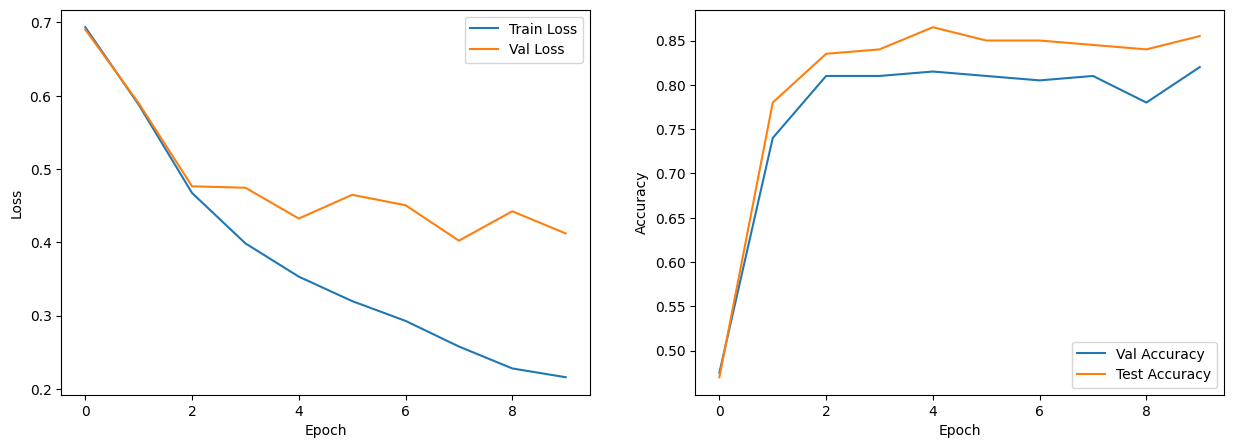

In [79]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [80]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6828, Validation Accuracy: 0.4750
Epoch 2: Train Loss: 0.6015, Validation Accuracy: 0.7650
Epoch 3: Train Loss: 0.4900, Validation Accuracy: 0.7850
Epoch 4: Train Loss: 0.4206, Validation Accuracy: 0.8000
Epoch 5: Train Loss: 0.3572, Validation Accuracy: 0.8000
Epoch 6: Train Loss: 0.3659, Validation Accuracy: 0.8150
Epoch 7: Train Loss: 0.3170, Validation Accuracy: 0.8050
Epoch 8: Train Loss: 0.2830, Validation Accuracy: 0.8150
Epoch 9: Train Loss: 0.2585, Validation Accuracy: 0.8100
Epoch 10: Train Loss: 0.2629, Validation Accuracy: 0.8050

Final Test Accuracy: 0.8250


Epoch 1: Train Loss: 0.6991, Val Loss: 0.6916, Val Acc: 0.4750, Test Acc: 0.4700
Epoch 2: Train Loss: 0.6385, Val Loss: 0.6776, Val Acc: 0.4950, Test Acc: 0.5050
Epoch 3: Train Loss: 0.5485, Val Loss: 0.5864, Val Acc: 0.8000, Test Acc: 0.8150
Epoch 4: Train Loss: 0.4524, Val Loss: 0.5166, Val Acc: 0.8050, Test Acc: 0.8300
Epoch 5: Train Loss: 0.3752, Val Loss: 0.4591, Val Acc: 0.8050, Test Acc: 0.8450
Epoch 6: Train Loss: 0.3492, Val Loss: 0.4794, Val Acc: 0.8100, Test Acc: 0.8400
Epoch 7: Train Loss: 0.3298, Val Loss: 0.4324, Val Acc: 0.8150, Test Acc: 0.8500
Epoch 8: Train Loss: 0.2854, Val Loss: 0.4439, Val Acc: 0.8100, Test Acc: 0.8400
Epoch 9: Train Loss: 0.2996, Val Loss: 0.4492, Val Acc: 0.8100, Test Acc: 0.8400
Epoch 10: Train Loss: 0.2553, Val Loss: 0.4551, Val Acc: 0.8050, Test Acc: 0.8350


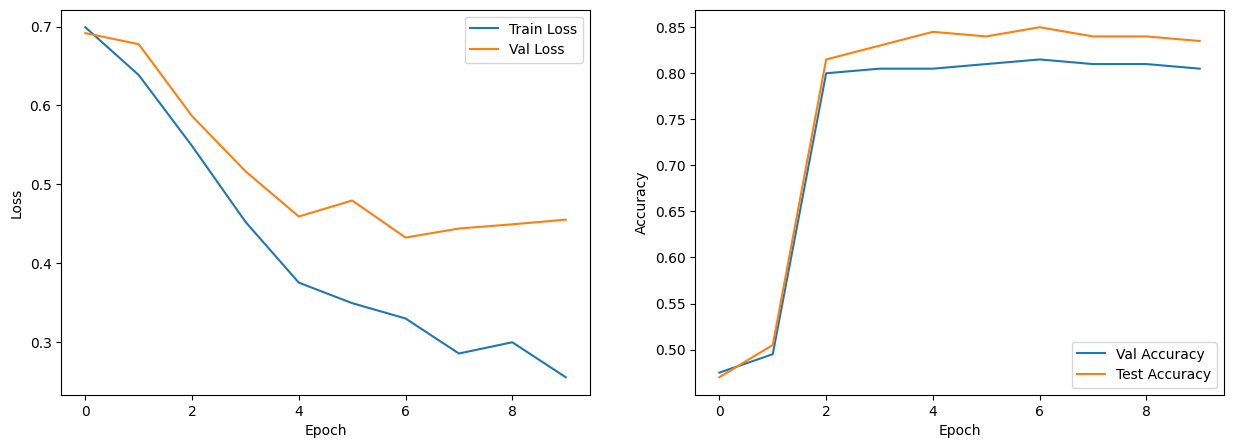

In [81]:
batch_size = 64
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Trying the model on another simulated dataset, having a much longer protein sequence length.

In [82]:
datalist2, labellist2 = read(seqfile = "/content/grs34806-deep-learning-project-data/len200_500_n5000nr4.seq",
posfile = "/content/grs34806-deep-learning-project-data/len200_500_n5000nr4.pos")

Length of the datalist:  5000
Length of labellist:  5000
The number of positives in labellist:  2490


In [83]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = generate_train_val_test(
    datalist2, labellist2
)

In [84]:
print("Training data size:", len(train_data))
print("Training labels size:", len(train_labels))
print("Validation data size: ", len(val_data))
print("Validation labels size: ", len(val_labels))
print("Test data size:", len(test_data))
print("Test labels size:", len(test_labels))

Training data size: 3000
Training labels size: 3000
Validation data size:  1000
Validation labels size:  1000
Test data size: 1000
Test labels size: 1000


In [85]:
train_iter_newdata = load_data(batch_size = 25, num_steps=200, dataset=train_data, trainlabels=train_labels)
validation_iter_newdata = load_data(batch_size=25, num_steps=200, dataset=val_data, trainlabels=val_labels)
test_iter_newdata = load_data(batch_size= 25, num_steps = 200, dataset = test_data, trainlabels = test_labels)

Running the model with a larger context size with the CNN model with batch normalisation. The context size was increased as the minimum length of the sequences now was 200. To get better performance, we increased the length of the amino acids the model looks at to learn better.

In [90]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter_newdata = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter_newdata:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter_newdata:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 1.3369, Validation Accuracy: 0.6690
Epoch 2: Train Loss: 1.1792, Validation Accuracy: 0.5690
Epoch 3: Train Loss: 1.0398, Validation Accuracy: 0.6440
Epoch 4: Train Loss: 0.9857, Validation Accuracy: 0.8210
Epoch 5: Train Loss: 0.9158, Validation Accuracy: 0.7270
Epoch 6: Train Loss: 0.8693, Validation Accuracy: 0.6460
Epoch 7: Train Loss: 0.8565, Validation Accuracy: 0.8070
Epoch 8: Train Loss: 0.8104, Validation Accuracy: 0.6960
Epoch 9: Train Loss: 0.8249, Validation Accuracy: 0.7380
Early stopping triggered at epoch 9

Final Test Accuracy: 0.7930


Epoch 1: Train Loss: 1.3393, Val Loss: 1.2931, Val Acc: 0.6150, Test Acc: 0.6710
Epoch 2: Train Loss: 1.2066, Val Loss: 1.2035, Val Acc: 0.7770, Test Acc: 0.7560
Epoch 3: Train Loss: 1.0714, Val Loss: 1.1774, Val Acc: 0.7050, Test Acc: 0.6670
Epoch 4: Train Loss: 0.9774, Val Loss: 1.3065, Val Acc: 0.5850, Test Acc: 0.5350
Epoch 5: Train Loss: 0.9080, Val Loss: 1.0808, Val Acc: 0.7890, Test Acc: 0.7580
Epoch 6: Train Loss: 0.8750, Val Loss: 0.9887, Val Acc: 0.8290, Test Acc: 0.7960
Epoch 7: Train Loss: 0.8593, Val Loss: 0.9814, Val Acc: 0.8220, Test Acc: 0.8030
Epoch 8: Train Loss: 0.8070, Val Loss: 1.0063, Val Acc: 0.8120, Test Acc: 0.7790
Epoch 9: Train Loss: 0.8030, Val Loss: 0.9359, Val Acc: 0.8280, Test Acc: 0.8020
Epoch 10: Train Loss: 0.7984, Val Loss: 0.9226, Val Acc: 0.8300, Test Acc: 0.8000


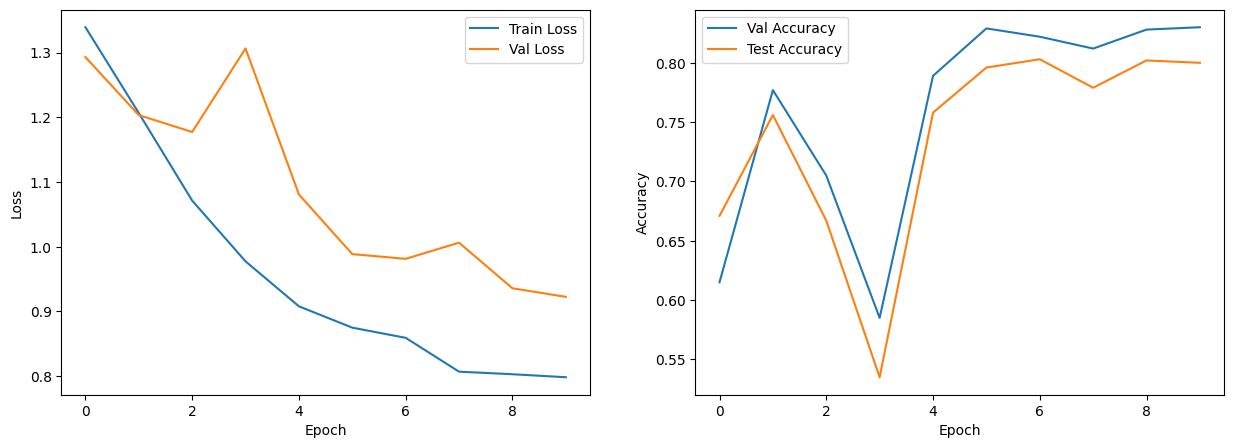

In [91]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [92]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter_newdata = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter_newdata:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter_newdata:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6849, Validation Accuracy: 0.6310
Epoch 2: Train Loss: 0.6199, Validation Accuracy: 0.7320
Epoch 3: Train Loss: 0.5465, Validation Accuracy: 0.6240
Epoch 4: Train Loss: 0.5139, Validation Accuracy: 0.7550
Epoch 5: Train Loss: 0.4811, Validation Accuracy: 0.7570
Epoch 6: Train Loss: 0.4492, Validation Accuracy: 0.5870
Epoch 7: Train Loss: 0.4163, Validation Accuracy: 0.7880
Epoch 8: Train Loss: 0.4163, Validation Accuracy: 0.8250
Epoch 9: Train Loss: 0.4082, Validation Accuracy: 0.8170
Epoch 10: Train Loss: 0.4042, Validation Accuracy: 0.8290

Final Test Accuracy: 0.8110


Epoch 1: Train Loss: 0.6800, Val Loss: 0.6704, Val Acc: 0.5660, Test Acc: 0.6020
Epoch 2: Train Loss: 0.6229, Val Loss: 0.6406, Val Acc: 0.6170, Test Acc: 0.5800
Epoch 3: Train Loss: 0.5631, Val Loss: 0.6004, Val Acc: 0.7140, Test Acc: 0.6830
Epoch 4: Train Loss: 0.5008, Val Loss: 0.5835, Val Acc: 0.7080, Test Acc: 0.6740
Epoch 5: Train Loss: 0.4695, Val Loss: 0.5189, Val Acc: 0.8200, Test Acc: 0.8060
Epoch 6: Train Loss: 0.4522, Val Loss: 0.5669, Val Acc: 0.7160, Test Acc: 0.6940
Epoch 7: Train Loss: 0.4162, Val Loss: 0.5794, Val Acc: 0.6860, Test Acc: 0.6680
Epoch 8: Train Loss: 0.4206, Val Loss: 0.5350, Val Acc: 0.7900, Test Acc: 0.7680
Epoch 9: Train Loss: 0.3998, Val Loss: 0.4751, Val Acc: 0.8260, Test Acc: 0.8060
Epoch 10: Train Loss: 0.3849, Val Loss: 0.4531, Val Acc: 0.8300, Test Acc: 0.8030


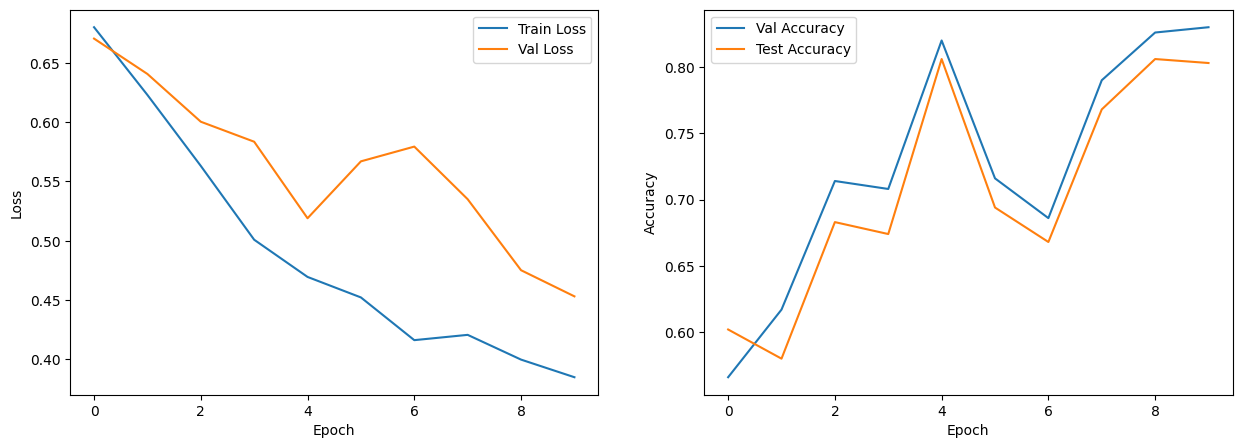

In [45]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Running the same dataset with similar hyperparameters but on the CNN with no batch normalisation. This was done to check the effect of batch normalisation on larger datasets with higher context size.

Epoch 1: Train Loss: 0.6960, Val Loss: 0.6930, Val Acc: 0.5300, Test Acc: 0.4910
Epoch 2: Train Loss: 0.6940, Val Loss: 0.6916, Val Acc: 0.5320, Test Acc: 0.4910
Epoch 3: Train Loss: 0.6931, Val Loss: 0.6937, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 4: Train Loss: 0.6942, Val Loss: 0.6930, Val Acc: 0.5320, Test Acc: 0.4910
Epoch 5: Train Loss: 0.6942, Val Loss: 0.6931, Val Acc: 0.5020, Test Acc: 0.5010
Epoch 6: Train Loss: 0.6934, Val Loss: 0.6935, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 7: Train Loss: 0.6923, Val Loss: 0.6896, Val Acc: 0.5100, Test Acc: 0.5600
Epoch 8: Train Loss: 0.6095, Val Loss: 0.5836, Val Acc: 0.7690, Test Acc: 0.7530
Epoch 9: Train Loss: 0.4740, Val Loss: 0.4580, Val Acc: 0.8400, Test Acc: 0.8160
Epoch 10: Train Loss: 0.4169, Val Loss: 0.4329, Val Acc: 0.8390, Test Acc: 0.8150


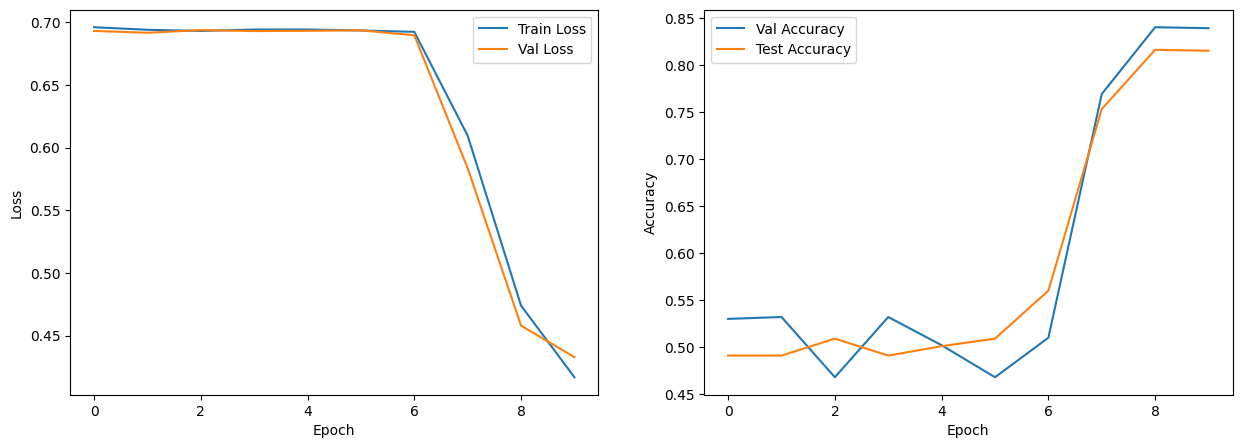

In [87]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [88]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter_newdata = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter_newdata:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter_newdata))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter_newdata:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6953, Validation Accuracy: 0.5010
Epoch 2: Train Loss: 0.6939, Validation Accuracy: 0.4660
Epoch 3: Train Loss: 0.6939, Validation Accuracy: 0.4920
Epoch 4: Train Loss: 0.6937, Validation Accuracy: 0.4600
Epoch 5: Train Loss: 0.6933, Validation Accuracy: 0.5320
Epoch 6: Train Loss: 0.6935, Validation Accuracy: 0.4680
Epoch 7: Train Loss: 0.6938, Validation Accuracy: 0.5320
Epoch 8: Train Loss: 0.6936, Validation Accuracy: 0.4940
Epoch 9: Train Loss: 0.6937, Validation Accuracy: 0.4680
Epoch 10: Train Loss: 0.6943, Validation Accuracy: 0.4680
Early stopping triggered at epoch 10

Final Test Accuracy: 0.4940


Epoch 1: Train Loss: 0.6954, Val Loss: 0.6925, Val Acc: 0.5320, Test Acc: 0.4910
Epoch 2: Train Loss: 0.6937, Val Loss: 0.6935, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 3: Train Loss: 0.6937, Val Loss: 0.6926, Val Acc: 0.5320, Test Acc: 0.4910
Epoch 4: Train Loss: 0.6936, Val Loss: 0.6939, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 5: Train Loss: 0.6946, Val Loss: 0.6931, Val Acc: 0.5540, Test Acc: 0.5210
Epoch 6: Train Loss: 0.6936, Val Loss: 0.6930, Val Acc: 0.5300, Test Acc: 0.4900
Epoch 7: Train Loss: 0.6935, Val Loss: 0.6926, Val Acc: 0.5320, Test Acc: 0.4910
Epoch 8: Train Loss: 0.6933, Val Loss: 0.6933, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 9: Train Loss: 0.6941, Val Loss: 0.6933, Val Acc: 0.4680, Test Acc: 0.5090
Epoch 10: Train Loss: 0.6907, Val Loss: 0.6876, Val Acc: 0.4840, Test Acc: 0.5260


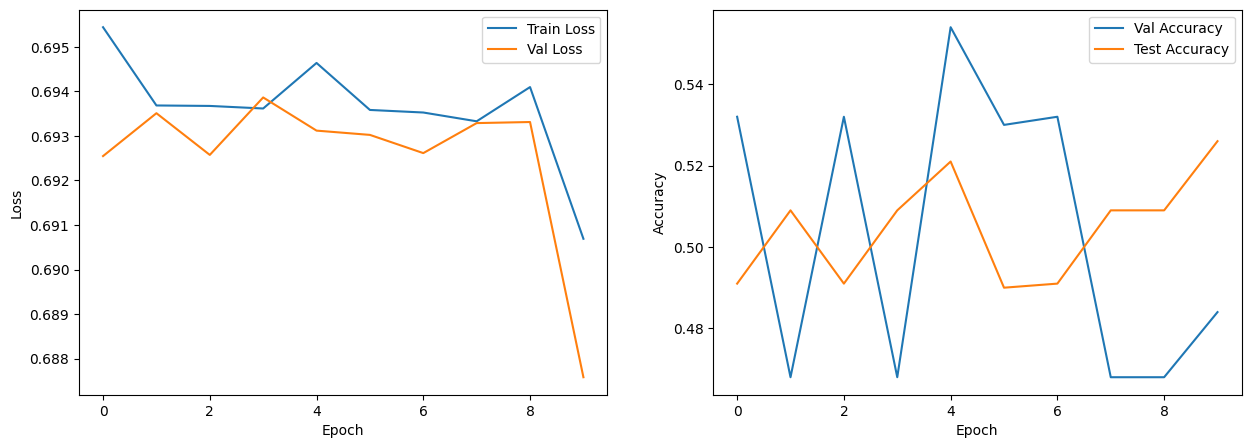

In [89]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Testing the performance of the model when the kernel size is increased from 3 to 5.

In [94]:
class BatchNorm_ProteinCNN1D_differentkernel(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4
               ):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=5, # Increased kernel size
                    padding='same',
                    bias=use_bias),
          nn.BatchNorm1d(conv_channels),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 5,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 5,
                    padding = 'same',
                    bias = use_bias),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.AdaptiveAvgPool1d(1),
          nn.Flatten(),
          nn.Linear(#in_features = int(128*(self.context_size//8)),
                    in_features = 128,
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



In [93]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D_differentkernel(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6480, Validation Accuracy: 0.7570
Epoch 2: Train Loss: 0.5430, Validation Accuracy: 0.5560
Epoch 3: Train Loss: 0.4617, Validation Accuracy: 0.6520
Epoch 4: Train Loss: 0.4241, Validation Accuracy: 0.7620
Epoch 5: Train Loss: 0.4030, Validation Accuracy: 0.6470
Epoch 6: Train Loss: 0.3951, Validation Accuracy: 0.8020
Epoch 7: Train Loss: 0.3801, Validation Accuracy: 0.7700
Epoch 8: Train Loss: 0.3389, Validation Accuracy: 0.6870
Epoch 9: Train Loss: 0.3338, Validation Accuracy: 0.7660
Epoch 10: Train Loss: 0.3154, Validation Accuracy: 0.8220

Final Test Accuracy: 0.7980


Epoch 1: Train Loss: 0.6443, Val Loss: 0.6418, Val Acc: 0.6040, Test Acc: 0.5800
Epoch 2: Train Loss: 0.5420, Val Loss: 0.5368, Val Acc: 0.8250, Test Acc: 0.8020
Epoch 3: Train Loss: 0.4771, Val Loss: 0.5377, Val Acc: 0.7970, Test Acc: 0.7630
Epoch 4: Train Loss: 0.4171, Val Loss: 0.5229, Val Acc: 0.8060, Test Acc: 0.7850
Epoch 5: Train Loss: 0.3988, Val Loss: 0.4795, Val Acc: 0.8290, Test Acc: 0.8080
Epoch 6: Train Loss: 0.3685, Val Loss: 0.5353, Val Acc: 0.7740, Test Acc: 0.7520
Epoch 7: Train Loss: 0.3499, Val Loss: 0.4497, Val Acc: 0.8220, Test Acc: 0.8050
Epoch 8: Train Loss: 0.3467, Val Loss: 0.4808, Val Acc: 0.8240, Test Acc: 0.8020
Epoch 9: Train Loss: 0.3251, Val Loss: 0.4531, Val Acc: 0.8300, Test Acc: 0.8110
Epoch 10: Train Loss: 0.3100, Val Loss: 0.4815, Val Acc: 0.8120, Test Acc: 0.7890


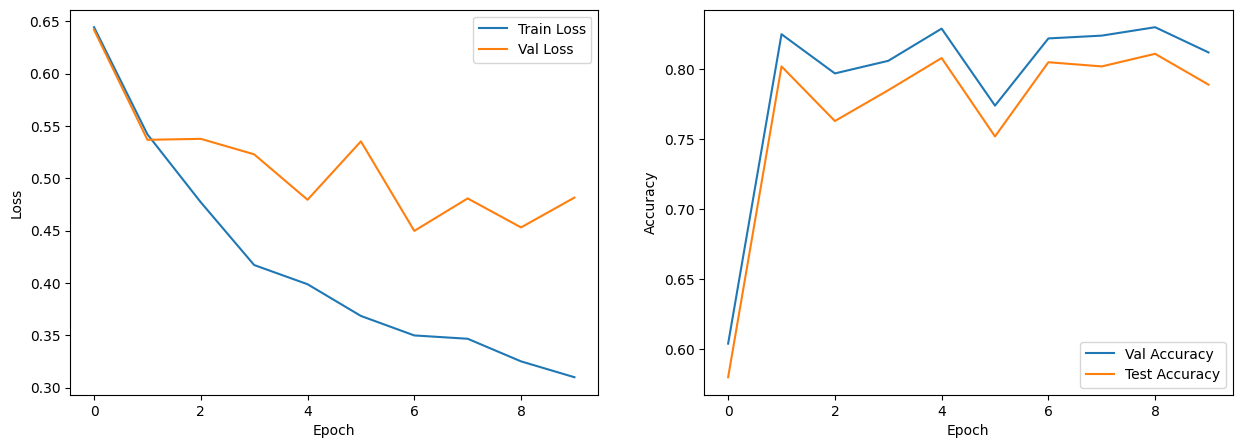

In [95]:
batch_size = 32
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D_differentkernel(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [96]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = BatchNorm_ProteinCNN1D_differentkernel(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.6655, Validation Accuracy: 0.6700
Epoch 2: Train Loss: 0.5805, Validation Accuracy: 0.5320
Epoch 3: Train Loss: 0.4927, Validation Accuracy: 0.8280
Epoch 4: Train Loss: 0.4436, Validation Accuracy: 0.6920
Epoch 5: Train Loss: 0.4136, Validation Accuracy: 0.8300
Epoch 6: Train Loss: 0.3851, Validation Accuracy: 0.8310
Epoch 7: Train Loss: 0.3665, Validation Accuracy: 0.8300
Epoch 8: Train Loss: 0.3493, Validation Accuracy: 0.8040
Epoch 9: Train Loss: 0.3297, Validation Accuracy: 0.8250
Epoch 10: Train Loss: 0.3117, Validation Accuracy: 0.8320

Final Test Accuracy: 0.8130


Epoch 1: Train Loss: 0.6842, Val Loss: 0.6730, Val Acc: 0.6070, Test Acc: 0.6120
Epoch 2: Train Loss: 0.6588, Val Loss: 0.6604, Val Acc: 0.5980, Test Acc: 0.6180
Epoch 3: Train Loss: 0.6313, Val Loss: 0.6427, Val Acc: 0.6170, Test Acc: 0.6240
Epoch 4: Train Loss: 0.5979, Val Loss: 0.6346, Val Acc: 0.6010, Test Acc: 0.6170
Epoch 5: Train Loss: 0.5727, Val Loss: 0.6450, Val Acc: 0.5390, Test Acc: 0.5620
Epoch 6: Train Loss: 0.5566, Val Loss: 0.6176, Val Acc: 0.6500, Test Acc: 0.6370
Epoch 7: Train Loss: 0.5321, Val Loss: 0.6134, Val Acc: 0.6460, Test Acc: 0.6290
Epoch 8: Train Loss: 0.4936, Val Loss: 0.6183, Val Acc: 0.6510, Test Acc: 0.6300
Epoch 9: Train Loss: 0.4893, Val Loss: 0.6335, Val Acc: 0.6490, Test Acc: 0.6310
Epoch 10: Train Loss: 0.4529, Val Loss: 0.6288, Val Acc: 0.6320, Test Acc: 0.6300


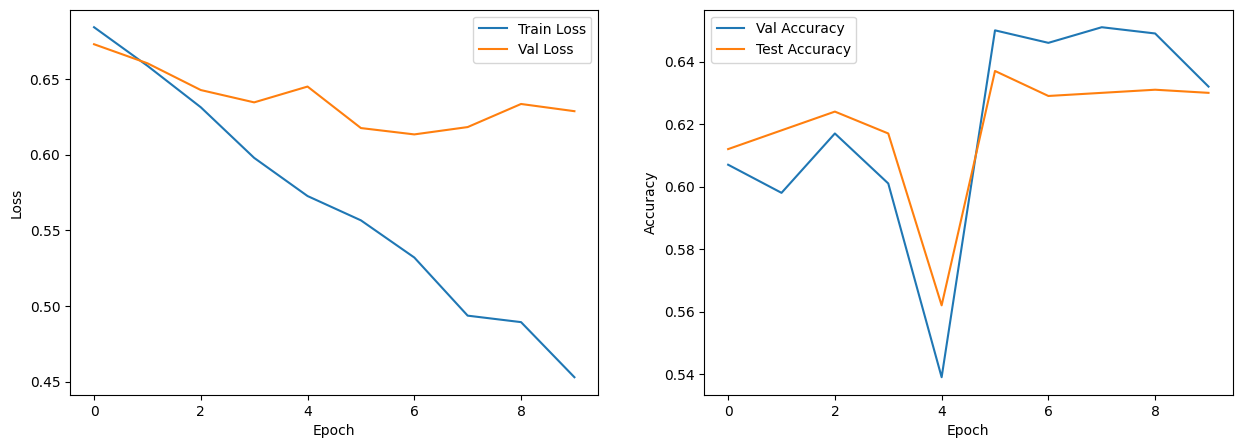

In [48]:
batch_size = 64
context_size = 200
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter_newdata = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter_newdata = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter_newdata = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = BatchNorm_ProteinCNN1D_differentkernel(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter_newdata:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter_newdata:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()